In [1]:
# =====================================================
# STEP 1: IMPORT LIBRARIES
# =====================================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2025-10-27 23:21:50.131295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761607310.339158      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761607310.392470      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# =====================================================
# STEP 2: LOAD PREPROCESSED DATA
# =====================================================
# Replace 'preprocessed-inthewild' with your dataset name on Kaggle
X_train = np.load('/kaggle/input/preprocessed-inthewild/X_train.npy')
X_val   = np.load('/kaggle/input/preprocessed-inthewild/X_val.npy')
X_test  = np.load('/kaggle/input/preprocessed-inthewild/X_test.npy')

y_train = np.load('/kaggle/input/preprocessed-inthewild/y_train.npy')
y_val   = np.load('/kaggle/input/preprocessed-inthewild/y_val.npy')
y_test  = np.load('/kaggle/input/preprocessed-inthewild/y_test.npy')

print("Data loaded successfully!")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

Data loaded successfully!
X_train: (22245, 128, 94, 1)
X_val: (4767, 128, 94, 1)
X_test: (4767, 128, 94, 1)
y_train: (22245,)
y_val: (4767,)
y_test: (4767,)


In [3]:
# =====================================================
# STEP 3: RESHAPE DATA FOR LSTM INPUT
# =====================================================
# LSTM expects 3D input: (samples, timesteps, features)
# If your data is 4D (e.g., CNN spectrograms), flatten spatial dims
if len(X_train.shape) == 4:
    n_samples, n_height, n_width, n_channels = X_train.shape
    X_train = X_train.reshape(n_samples, n_height, n_width * n_channels)
    X_val   = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2] * X_val.shape[3])
    X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3])

print("Reshaped for BiLSTM input:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

Reshaped for BiLSTM input:
X_train: (22245, 128, 94)
X_val: (4767, 128, 94)
X_test: (4767, 128, 94)


In [4]:
# =====================================================
# STEP 4: DEFINE BiLSTM MODEL
# =====================================================
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.2)),
    BatchNormalization(),
    
    Dense(64, activation='relu'),
    Dropout(0.4),
    
    Dense(1, activation='sigmoid')  # Binary classification (Real/Fake)
])

model.summary()

I0000 00:00:1761607329.680928      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761607329.681676      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128, 256)       │       228,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,561 (1.54 MB)

 Trainable params: 401,793 (1.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [5]:
# =====================================================
# STEP 5: COMPILE MODEL
# =====================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [6]:
# =====================================================
# STEP 6: DEFINE CALLBACKS
# =====================================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # stop if val_loss doesn't improve for 4 epochs
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.5,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_bilstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [7]:
# =====================================================
# STEP 7: TRAIN THE MODEL
# =====================================================
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/40
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.6741 - loss: 0.6340
Epoch 1: val_loss improved from inf to 0.35571, saving model to best_bilstm_model.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 726s 1s/step - accuracy: 0.6742 - loss: 0.6338 - val_accuracy: 0.8519 - val_loss: 0.3557 - learning_rate: 5.0000e-04
Epoch 2/40
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.8394 - loss: 0.3993
Epoch 2: val_loss improved from 0.35571 to 0.29565, saving model to best_bilstm_model.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 705s 1s/step - accuracy: 0.8394 - loss: 0.3993 - val_accuracy: 0.8842 - val_loss: 0.2957 - learning_rate: 5.0000e-04
Epoch 3/40
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.8613 - loss: 0.3514
Epoch 3: val_loss improved from 0.29565 to 0.27067, saving model to best_bilstm_model.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 702s 1s/step - accuracy: 0.8613 - loss: 0.3514 - val_accuracy: 0.8953 - val_loss: 0.2707 - learning_rate: 5.0000e-04
Epoch 4/40
696/696 ━━━━━━━

In [8]:
# =====================================================
# STEP 8: EVALUATE ON TEST SET
# =====================================================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - accuracy: 0.9899 - loss: 0.0340

 Test Accuracy: 0.9910
 Test Loss: 0.0297


In [9]:
# =====================================================
# STEP 9: SAVE TRAINED BiLSTM MODEL
# =====================================================
model.save("/kaggle/working/deepfake_audio_bilstm_model.h5")
print("Model saved as deepfake_audio_bilstm_model.h5 successfully!")

Model saved as deepfake_audio_bilstm_model.h5 successfully!


149/149 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step

========== MODEL PERFORMANCE ON TEST SET ==========
 Accuracy  : 0.9910
 Precision : 0.9960
 Recall    : 0.9797
 F1-score  : 0.9878


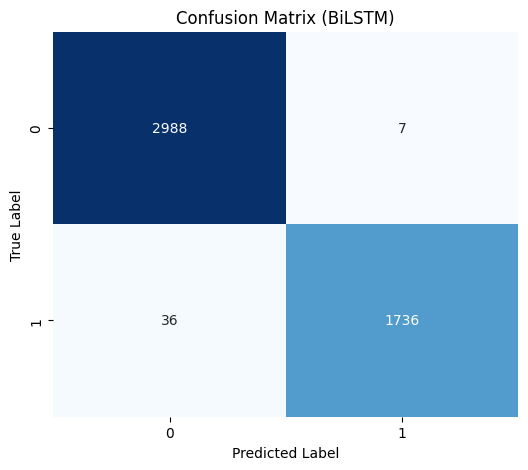

In [10]:
# =====================================================
# STEP 10: MODEL EVALUATION & PERFORMANCE METRICS
# =====================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Predictions ---
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# --- Metrics ---
test_acc = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred)
test_rec = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("\n========== MODEL PERFORMANCE ON TEST SET ==========")
print(f" Accuracy  : {test_acc:.4f}")
print(f" Precision : {test_prec:.4f}")
print(f" Recall    : {test_rec:.4f}")
print(f" F1-score  : {test_f1:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (BiLSTM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

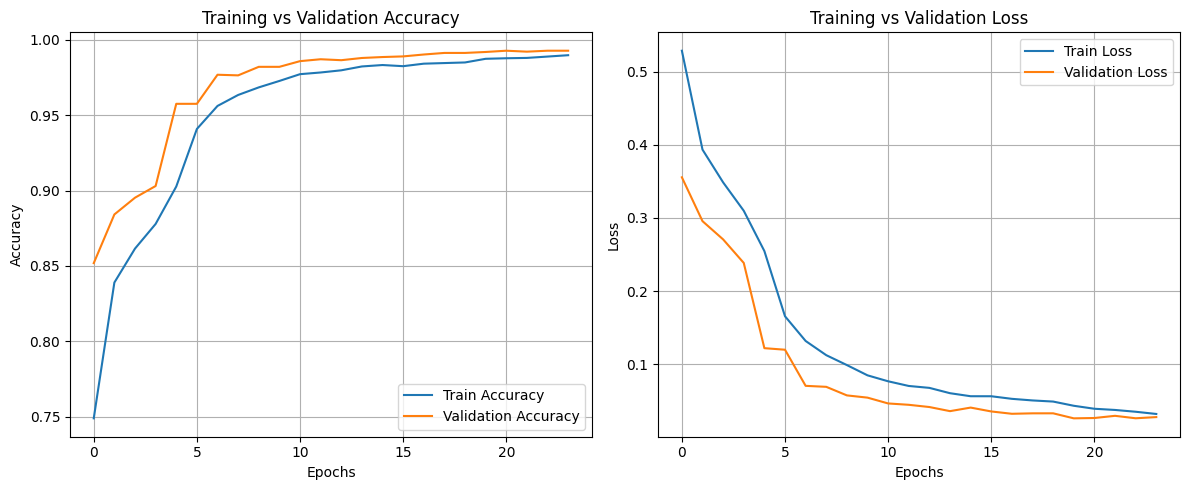

In [11]:
# =====================================================
# STEP 11: TRAINING PERFORMANCE GRAPHS
# =====================================================
plt.figure(figsize=(12,5))

# --- Accuracy Curve ---
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# --- Loss Curve ---
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

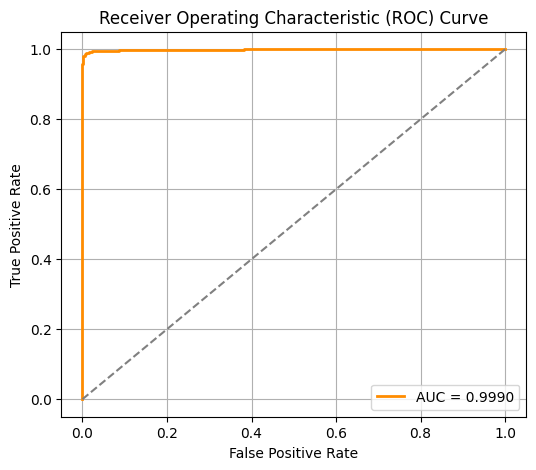

In [12]:
# =====================================================
# STEP 12: ROC CURVE
# =====================================================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()